In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit
import h5py


In [2]:
import os
class DepthDataset(Dataset):
    def __init__(self, data_dir):
        self.data_files=[]
        folders=os.listdir(data_dir+'/RGB')
        for folder in folders:
            subfolders=os.listdir(data_dir+'/RGB/'+folder)
            for subfolder in subfolders:
                if subfolder.startswith('.'):
                    continue
                files=os.listdir(data_dir+'/RGB/'+folder+'/'+subfolder)
                for file in files:
                    if file.endswith('.mat'):
                        self.data_files.append(folder+'/'+ subfolder+'/'+file)
            self.data_dir=data_dir
#         sort(self.data_files)      

    def __getitem__(self, index):
        name=self.data_files[index]
        img=torch.from_numpy(h5py.File(self.data_dir+'/RGB/'+name,'r')['rgbOut'].value).float()
        depth=torch.from_numpy(h5py.File(self.data_dir+'/DEP/'+name,'r')['depthOut'].value).float()
        return img,depth

    def __len__(self):
        return len(self.data_files)

In [7]:
dataset=DepthDataset('../Data_liv')
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter((torch.randperm(self.num_samples)+self.start).long())

    def __len__(self):
        return self.num_samples

In [8]:
N=dataset.__len__()
NUM_TRAIN = int(N*0.9)
NUM_VAL = N-NUM_TRAIN
print("NUM_TRAIN:",NUM_TRAIN,",NUM_VAL:",NUM_VAL)
batch_size=8
loader_train = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),num_workers=8)
loader_val = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),num_workers=8)


dtype = torch.cuda.FloatTensor

NUM_TRAIN: 673 ,NUM_VAL: 75


## Load  Loss Data

In [15]:
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
loss0 = pickle.load(open('train_liv/save_train_prev/losses_ep0.pickle', 'rb'))
print(loss0)


[[4.921622126560493], [2.726865905846281]]


In [13]:
loss0[1][0]

2.726865905846281

53


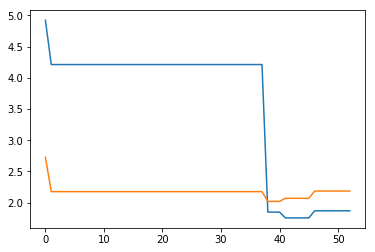

In [16]:
loss_dir = 'train_liv/save_train_prev/'
train_loss = []
val_loss = []
for i in range(56):
    file_dir = loss_dir + 'losses_ep' + str(i) + '.pickle'
    if os.path.isfile(file_dir):
        loss_hist = pickle.load(open(file_dir, 'rb'))
        train_loss.append(loss_hist[0][0])
        val_loss.append(loss_hist[1][0])

print(len(train_loss))
plt.plot(train_loss)
plt.plot(val_loss)

In [18]:
print(train_loss[0], val_loss[0])

4.921622126560493 2.726865905846281


# Evaluate

In [29]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # \"flatten\" the C * H * W values into a single vector per image
    

class Unflatten(nn.Module):
    def __init__(self,w,h):
        super(Unflatten,self).__init__()
        self.w=w
        self.h=h
    def forward(self, x):
        N, S = x.size() # read in N, C, H, W
        return x.view(N, self.w, self.h)  # \"flatten\" the C * H * W values into a single vector per image

class crop(nn.Module):
    def forward(self,x):
        N,C,H,W = x.size()
        return x[:,:,0:H-1,0:W-1].squeeze()
class printLayer(nn.Module):
    def forward(self,x):
        print('layer size:',x.size())
        #print('max element:', x.max())
        return x

In [30]:
# load model
coarse_model=nn.Sequential(
        nn.Conv2d(3,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,50,3,stride=1, padding=1),
        #printLayer(),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Conv2d(50,80,3,stride = 2,padding=0),
        #printLayer(),
        nn.BatchNorm2d(80),
        nn.ReLU(),
        nn.Conv2d(80,100,3,stride = 1,padding=1),
        #printLayer(),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.Conv2d(100,200,3,stride=2,padding=0),
        #printLayer(),
        nn.BatchNorm2d(200),
        nn.ReLU(),
        nn.Conv2d(200,220,3,stride=1,padding=1),
        #printLayer(),
        nn.BatchNorm2d(220),
        nn.ReLU(),
        #nn.ConvTranspose2d(360, 100, 3, stride = 4, padding=2,output_padding=1),
        #nn.BatchNorm2d(100),
        #nn.ReLU(),
        nn.Conv2d(220,1,1,stride=1,padding=0),
        crop()
    )
coarse_model.type(dtype)

Sequential (
  (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU ()
  (3): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU ()
  (6): Conv2d(50, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (8): ReLU ()
  (9): Conv2d(50, 80, kernel_size=(3, 3), stride=(2, 2))
  (10): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True)
  (11): ReLU ()
  (12): Conv2d(80, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (14): ReLU ()
  (15): Conv2d(100, 200, kernel_size=(3, 3), stride=(2, 2))
  (16): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
  (17): ReLU ()
  (18): Conv2d(200, 220, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (19): BatchNorm2d(220, eps=1e-05, m

In [39]:
coarse_model.load_state_dict(torch.load('train_liv/save_train_prev/alldata_dict_ep44'))

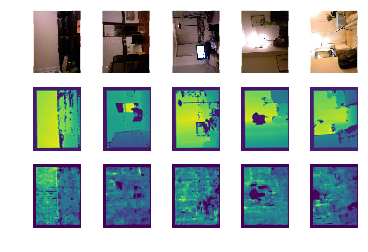

In [41]:
%matplotlib inline

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# visualize 5 images
NUM_SHOW=5
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    coarse_model.train(False)
    pred=coarse_model(x_var)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,:,:].data.numpy()
        img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

In [44]:
def evaluate(loader):
    ep = 1e-7

    thresh_1 = 0
    thresh_2 = 0
    abs_diff = 0
    rmse = 0

    for t,(x,y) in enumerate(loader):
        x_var=Variable(x.type(dtype),requires_grad=False)
        y_var=Variable(y.type(dtype),requires_grad=False)
        coarse_model.train(False)
        pred=coarse_model(x_var)

        #print(y_var.data.cpu().numpy())
        y_var=y_var.data.cpu().numpy()
        y_var = np.exp(y_var) + ep
        pred=pred.data.cpu().numpy() + ep
        num_var = np.shape(y_var)[0]*np.shape(y_var)[1]*np.shape(y_var)[2]

        # threshold
        thresh_mat = np.zeros_like(y_var)
        thresh_mat[np.maximum(y_var / pred, pred / y_var) < 1.25] = 1
        thresh_1 += np.sum(thresh_mat)
        thresh_2 += num_var
        #print('t1 = %d, t2 = %d', thresh_1, thresh_2)

        # relative absolute diffe
        abs_diff += np.sum(np.absolute(y_var - pred) / y_var) / num_var

        rmse += np.sqrt(np.sum((y_var - pred) * (y_var - pred)) / num_var)
        


    abs_diff /= len(loader)
    rmse /= len(loader)

    print('percentage within threshold: ', thresh_1 / thresh_2)
    print('relative absolute diff = ', abs_diff)
    print('rmse = ', rmse)

In [45]:
evaluate(loader_val)

percentage within threshold:  0.304829431985
relative absolute diff =  2.84371768825
rmse =  27.9049518045


Run the following cell to evaluate the performance of the forward pass running on the CPU: